# Simulation of the $XY$ Transverse Field Ising Model with a Random $Z$ Field

In this notebook, we simulate the $XY$ transverse field Ising model with a random $Z$ field. 

* Our initial objective is to reproduce the results presented in Figure 4 of [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728).
* Subsequently, we utilize the ansatz based on the multi-product formula to conduct a comparative analysis for our project.

We start by importing necessary libraries etc.

In [1]:
# Importing necessary packages
# - `numpy` for numerical operations
# - `matplotlib` for plotting
# - `sys` for system-related functions
# - `time` for recording time
# - `qiskit` for quantum simulations

import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import qiskit

from qiskit.quantum_info import Pauli, Statevector, SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler.passes import Decompose

### WARNING: COPY YOUR DIRECTORY'S PATH BELOW BEFORE RUNNING CODE ON YOUR LOCAL MACHINE  ###
sys.path.append("/Users/junaida/Documents/MPF-Cartan/")

from Cartan_Decomposition import cartan

## Cartan Decomposition of Hamiltonian

We generate the Cartan decomposition of the Hamiltonian corresponding to the transverse field XY model with a random Z field, as described in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). The three steps of the algorithm are implemented sequentially.

### 1) Generate Hamiltonian:
We define a function, `gen_hamiltonian`, to generate the Hamiltonian for the transverse field XY model with a random Z field. The `gen_hamiltonian` function takes the following as input: 

* `num_qubits`: Number of qubits.  
* `mean`: Mean of normal distribution.
* `std_deviation`: Standard deviation of normal distribution.  

`gen_hamiltonian` returns a class representing the Hamiltonian for the transverse field XY model with a random Z field.

In [2]:
#The function below assumes that the that the XY model with a random Z field is to be generated.

model = 'tfxy' # This will be used to generate the Hamiltonian of the form XXII + YYII + a_1*ZIII + ...

def gen_hamiltonian(num_qubits, mean, std_deviation):
    
    random_coeffs = [np.random.normal(mean, std_deviation) for i in range(num_qubits)]
    coefficients = random_coeffs + [1]*2*(num_qubits-1)
    modelTuple = [(coefficients, model)]
    
    tfxyH = cartan.Hamiltonian(num_qubits, name=modelTuple)
    
    return tfxyH

### 2) Cartan Decomposition

We now define two functions that compute the Cartan decomposition of the Hamiltonian algebra.

* `pile` implements the simplification of the $k$-algebra in Cartan decomposition for the $XY$ transverse field Ising model as introduced in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). We will make use of this function below.
* `decompose_Cartan` implements the Cartan decomposition and returns the Cartan decomposition of the Hamiltonian. Note that `decompose_Cartan` assumes the `CountY` involution can indeed be applied. Additional functionality will be incorporated in future updates.

In [3]:
def pile(N):
    k = []
    for i in range(N-1):
        for j in range(N-i-1):
            elem = (0,)*j+(2,1)+(0,)*(N-j-2)
            k.append(elem)
            
            elem = (0,)*j+(1,2)+(0,)*(N-j-2)
            k.append(elem)
    return k

#Warning: the function below implements the CountY involution under the assumption that it can indeed be implemeneted.
#Add more functionality later on.

def decompose_Cartan(num_qubits, mean, std_deviation):
    
    tfxyH = gen_hamiltonian(num_qubits, mean, std_deviation)
    tfxyC = cartan.Cartan(tfxyH, involution='countY')

    #Simplified k algebra
    tfxyC.k = pile(num_qubits)

    return tfxyC

### 3) Parameter Optimization

We implement a function `parameter_optimize` that performs the parameter optimization step to compute the $KHK$ decomposition of the Hamiltonian. The default approach employs gradient descent using the BFGS orom in the `scipy.optimize`.

In [4]:
def khk_decomposition(mean,std_deviation,num_qubits):

    #Cartan Decomposition
    tfxyC = decompose_Cartan(num_qubits, mean, std_deviation)
    
    #Generate the Parameters via:
    tfxyP = cartan.FindParameters(tfxyC)

    return tfxyC, tfxyP

#printResult() returns the parameters, the error produced by removing invalid terms, and the normed difference of the Cartan and the exact matrix exponentiation. 
#tfxyP.printResult()

We now initialize the model parameters and generate the KHK decomposition of the Hamiltonian.

In [5]:
#model parameters
mean = 0
std_deviation = 0
num_qubits = 5

#Generate KHK decomposition
tfxyC, tfxyP = khk_decomposition(mean,std_deviation,num_qubits);

Optimization terminated successfully.
         Current function value: -3.148645
         Iterations: 102
         Function evaluations: 112
         Gradient evaluations: 112
--- 4.141403913497925 seconds ---
Optimization Error:
3.790355607480029e-10


## Quantum Circuit Generation

We implement two functions that will enable us to generate the desired quantum circuits:

* We first implement a function `pauli_circuit` that generates a quantum circuit for $e^{-i t P}$ for a Pauli string $P$. The `pauli_circuit` function takes the following as input: 

    * `num_qubits`: Number of qubits.  
    * `pauli_list`: Mean of normal distribution.
    * `pauli_coeffs`: Standard deviation of normal distribution.
    * `evolution_time`: Evolution time of system.

`pauli_circuit` returns a quantum circuit represented in Qiskit. Our method is based on the approach summarized in Section 4 of [arXiv:1001.3855](https://arxiv.org/pdf/1001.3855). The implementation uses `Qiskit` and leverages its built-in functionality.

* We then implement a function `circuit_generate` that generates a quantum circuit that implements $e^{-itH}$. The `pauli_circuit` function takes the following as input: 

    * `time`: Evolution time. 
    * `cartan_hamiltonian`: KHK decomoposition of Hamiltonian, $H= K h K^\dagger$.
    * `circuit`: A Qiskit class representing a quantum circuit.
      
`circuit_generate` returns a quantum circuit that implements
$$e^{-itH} = K e^{-i h t} K^\dagger$$ 
We implement $K$ using the the first-order product formula ansatz in Eq. (8) in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728).

In [6]:
# Mapping of integers to Pauli matrices: 0 = I, 1 = X, 2 = Y, 3 = Z
mapping = {0: 'I', 1: 'X', 2: 'Y', 3: 'Z'}

def pauli_circuit(num_qubits,pauli_list,pauli_coeffs,evolution_time):

    circuit = QuantumCircuit(num_qubits)
    length = len(pauli_list)

    for i in range(length):
    
        map_to_string = np.vectorize(lambda x: mapping[x])
        pauli_string = ''.join(map_to_string(pauli_list[i]))
        
        # #WARNING: Should we Reverse the Pauli string? I think so.
        pauli_string = pauli_string[::-1]
    
        #WARNING: Accepts only real parameters. What if parameter is np.complex?! Look at this later on. 
        gate = PauliEvolutionGate(Pauli(pauli_string), time=evolution_time*np.real(pauli_coeffs[i]))  
        
        circuit.compose(gate,inplace=True)
        circuit.barrier()

    return circuit

def circuit_generate(time,cartan_hamiltonian,circuit):

    #We first implement e^{-iht}
    circuit_h = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.h,cartan_hamiltonian.hCoefs,time)
    
    #We now implement K
    circuit_k = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.k,cartan_hamiltonian.kCoefs,1)
    
    #We now implement K_dagger
    circuit_k_dagger = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.k[::-1],cartan_hamiltonian.kCoefs[::-1],-1)

    circuit.compose(circuit_k_dagger, inplace=True) 
    circuit.compose(circuit_h, inplace=True) 
    circuit.compose(circuit_k, inplace=True) 

    return circuit

## Results

We now implement a function `model_simulate` that allows us to simulate the model. The `model_simulate` function takes the following as input: 

* `evolution_time`: Evolution time of system.
* `time_step`: Time step determining the increment for which the system evolution is generated with the initial state $\ket{\psi_0} = \ket{ \downarrow \uparrow \uparrow \cdots \uparrow}$.
* `mean`, `std_deviation`: Parameters of the normal distribution used to generate the random $Z$ field.  
* `observable`: The observable whose expected value is computed.  

The function returns a list of expected values of the `observable`.

In [7]:
def model_simulate(evolution_time,time_step,num_qubits,mean,std_deviation,observable):
    
    #list to store expected values
    expected_value_observable = list()
    
    for t in np.arange(0,evolution_time+time_step,time_step):

        #Initialize quantum circuit
        initial_circuit = QuantumCircuit(num_qubits)
            
        #Set the initial state. 
        initial_circuit.x(0)
        initial_circuit.barrier()
    
        #Implement e^(-itH)
        circuit = circuit_generate(t,tfxyP,initial_circuit)
        
        #Execute quantum circuit
        psi = Statevector(circuit)
        
        #Measure expected value operator square
        expected_value_observable.append(psi.expectation_value(observable))
        
    #Return list of expected values
    return expected_value_observable

We now attempt to replicate the results presented in Figure 4 of [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). We take the following steps:

* Intialize evolution time and time step size.
* We define the `observable`
$$
\hat{N} = \sum_{r=1}^{n} \frac{r - 1}{2}(I - Z_r)
$$
* We call the `model_simulate` to simulate the model.
* We compute $\bra{\psi_t} \hat{N}^2 \ket{\psi_t}$ and plot our findings.

In [8]:
#total evolution time and time step
evolution_time = 20
time_step = 0.05

# Define the operator hat_N
interactions = [("I", [0], num_qubits*(num_qubits-1)/4)]

### WARNING. DOUBLE CHECK THIS LATER ONCheck if it should be num_qubits-r-1.
for r in range(num_qubits):
    interactions.append(("Z", [r], -0.5*r))

hat_N = SparsePauliOp.from_sparse_list(interactions, num_qubits)
observable = hat_N @ hat_N

#Generate data
t_values = np.arange(0, evolution_time + time_step, time_step)
expected_values = model_simulate(evolution_time,time_step,num_qubits,mean,std_deviation,observable)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


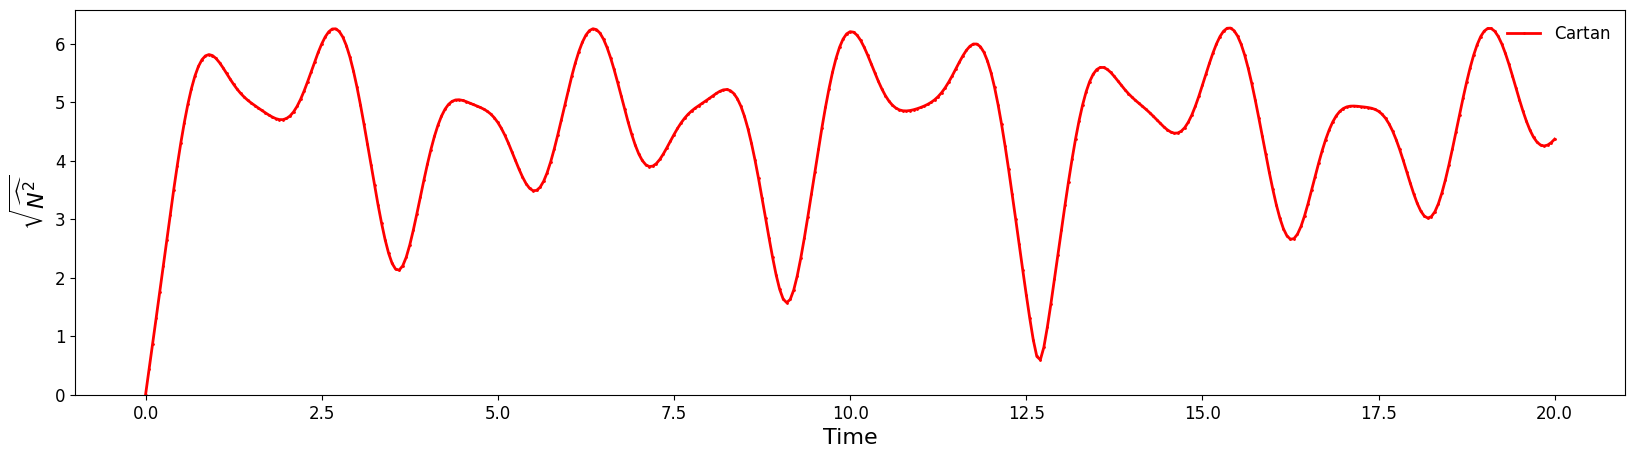

In [9]:
# Create the plot

#plt.style.use('default')

# Plot the original data points
plt.figure(figsize=(20, 5))
plt.plot(t_values, np.sqrt(expected_values), label=r'$\mathrm{Cartan}$', marker='o', color='red', markersize=1, linewidth=2)

# Enhance axes
plt.xlabel(r'Time', fontsize=16)
plt.ylabel(r'$\sqrt{\widehat{N^2}}$', fontsize=16)

# Ensure y-range starts from 0
plt.ylim(0, None)

# Add grid
#plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend
plt.legend(fontsize=12, loc='upper right', frameon=False, framealpha=0.9, edgecolor='black')

# Bold ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()